In [4]:
# imports

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mafese as mfse

2024-05-02 17:21:12.263087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 17:21:12.263144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 17:21:12.264764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
# loading the images
train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

# generator
def datagen(func):
  train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              horizontal_flip = True,
              vertical_flip = True,
              rotation_range = 0.5,
              width_shift_range = 0.25,
              height_shift_range = 0.25,
              shear_range = 0.2,
              zoom_range = 0.4,
              validation_split = 0.92)

  test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.8)

  test_gen_2 = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.2)

  pred_gen = tf.keras.preprocessing.image.ImageDataGenerator(
              preprocessing_function=func,
              validation_split = 0.92)

  train_set = train_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = True, subset = 'training')
  test_set = test_gen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='training')
  val_set = test_gen_2.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset='validation')
  pred_tr_set = pred_gen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 128, target_size = (224,224), shuffle = False, subset = 'training')
  return train_set, test_set, val_set, pred_tr_set

In [47]:
import shutil 

src_path = r"/kaggle/input/fake-image-model/densenet_final_2.keras"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

'/kaggle/working/densenet_final_2.keras'

In [48]:
model = tf.keras.models.load_model("/kaggle/working/densenet_final_2.keras")
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 730 variables whereas the saved optimizer has 70 variables. 



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,951,368 (79.92 MB)

 Trainable params: 6,955,906 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 13,911,814 (53.07 MB)

In [49]:
tr_set, te_set, v_set, pr_set = datagen(tf.keras.applications.densenet.preprocess_input)

Found 8000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [50]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

preds = model.predict(te_set)
preds

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



 1/32 ━━━━━━━━━━━━━━━━━━━━ 24:03 47s/step

W0000 00:00:1714672483.715988     220 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step 


W0000 00:00:1714672518.274846     220 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[5.3223580e-01, 4.6776417e-01],
       [9.9945945e-01, 5.4050743e-04],
       [9.8743671e-01, 1.2563281e-02],
       ...,
       [1.2386350e-03, 9.9876142e-01],
       [1.5816340e-03, 9.9841833e-01],
       [9.4212925e-01, 5.7870723e-02]], dtype=float32)

In [51]:
preds_f = preds.argmax(axis=1)
preds_f

array([0, 0, 0, ..., 1, 1, 0])

In [52]:
accuracy_score(te_set.labels, preds_f)

0.90675

In [53]:
recall_score(te_set.labels, preds_f, pos_label=0)

0.9025

In [54]:
precision_score(te_set.labels, preds_f)

0.903321764997521

In [55]:
f1_score(te_set.labels, preds_f)

0.9071446352999751

In [64]:
scores = [0.9105,
 0.906,
 0.90975,
 0.913,
 0.9125,
 0.92025,
 0.8975,
 0.90375,
 0.908,
 0.90375,
 0.89575,
 0.906,
 0.9205]


algos = ['OriginalGWO', 'RW_GWO', 'GWO_WOA', 'OriginalPSO', 'HPSO_TVAC', 'OriginalHS', 'HI_WOA', 'OriginalWOA', 'OriginalEFO', 'BaseGA', 
        'EliteMultiGA', 'MultiGA', 'OriginalCRO']

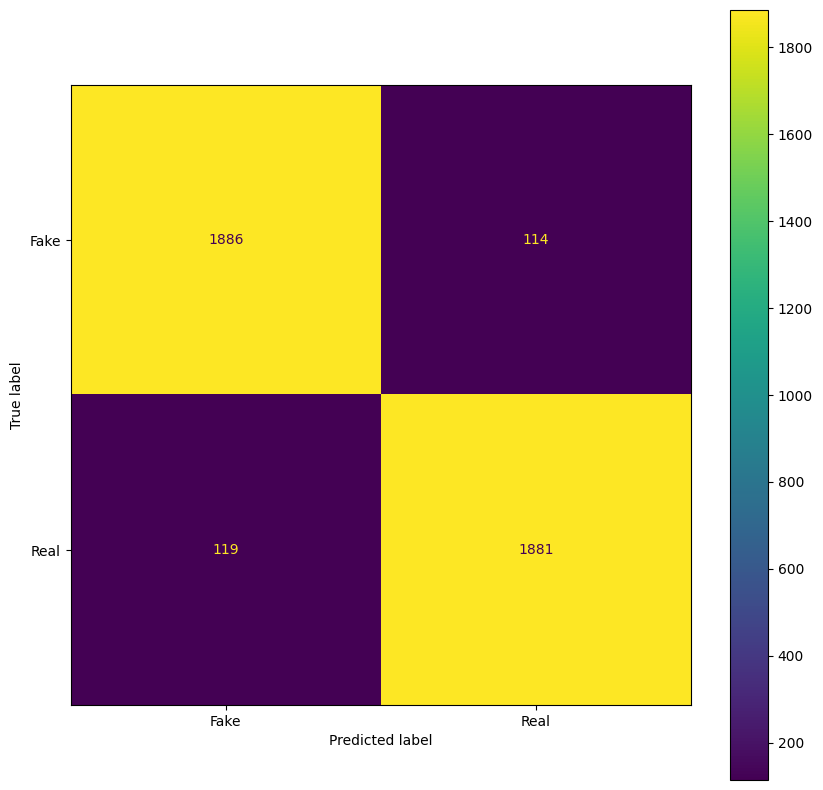

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(te_set.labels, preds_f)
f = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])
fig, ax = plt.subplots(figsize=(10,10))
f.plot(ax=ax)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



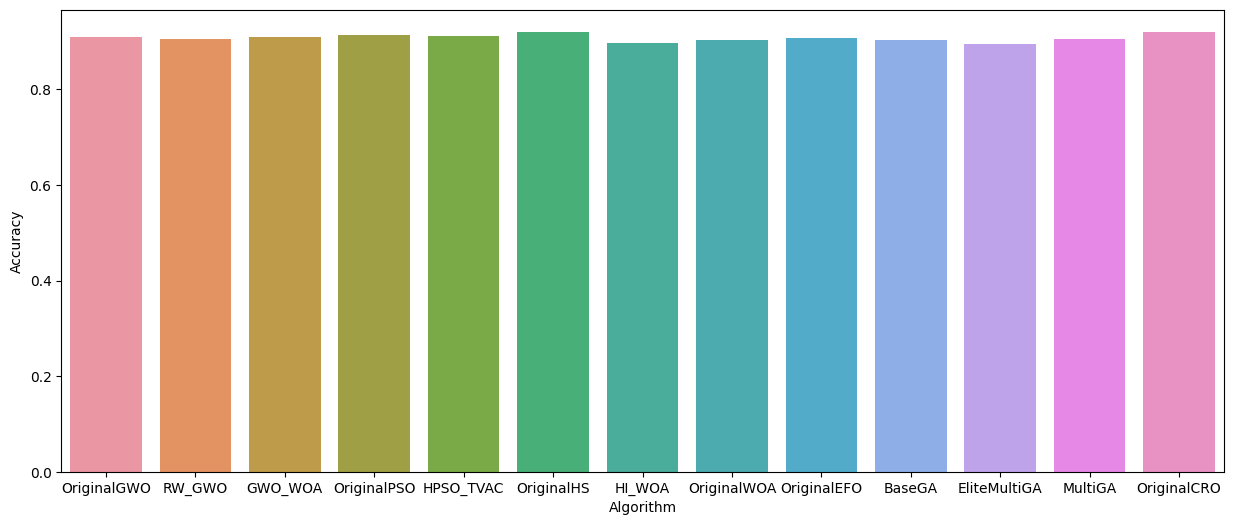

In [67]:
# scores chart

fig, ax = plt.subplots(figsize=(15,6))
bplot = sns.barplot(x=algos, y=scores, ax=ax)
bplot.set(xlabel='Algorithm', ylabel='Accuracy')
plt.savefig("fig.png")
plt.show()